In [1]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils
import time
from scipy.optimize import minimize
from tensorflow.contrib.opt.python.training import external_optimizer

%matplotlib inline

In [2]:
#################################################
# BELOW ARE ALL THE PARAMETERS USED IN THE CODE #
#################################################

# Printing the output
#
# i_max    is the maximum number of iterations that will be run
# i_print  is the amount of iterations after which the loss will be shown
# show     is whether or not the intermediate images will be shown
#
i_max   = 1000
i_print = 10
show    = True
optimizer_plot = True

# Weights
#
# gram_weight   is the amount of which the gram matrix contributes to the loss
# hist_weight   is the amount of which the histogram matching contributes to the loss
# tv_weight     is the amount of which the total variation contributes to the loss
#
gram_weight = 1.0
hist_weight = 0.001
tv_weight   = 1.0
#
# gram_layer_weight  is the amount of which each of the gram layers contribute to the loss
#                    layers are   [Conv1_1, Conv2_1, Conv3_1, Conv4_1 Conv5_1]
# hist_layer_weight  is the amount of which each of the hist layers contribute to the loss
#                    layers are   [Conv1_1, Conv4_1]
# tv_layer_weight    is the amount of which each of the total variation layers contribute to the loss
#                    layers are   [output, Conv1_1]
gram_layer_weight = [1.0, 1.0, 0.9, 0.5, 0.1]
hist_layer_weight = [1.0, 0.1]
tv_layer_weight   = [1.0, 1.0]

# Input noise generation
#
# noise_min   is the minimal value that any pixel color [RGB] can have in range [0,1]
# noise_max   is the maximal value that any pixal color [RGB] can have in range [0,1]
#
noise_min = 0.48
noise_max = 0.5

# Histogram Matching
#
# hist_range     is the range in which the bins will collect
# hist_bins      is how much bins will be generated within hist_range
# hist_grouping  how much features will be combined together in each layer
#                this is necessary if to much memory is used
#                layers are  [Conv1_1, Conv4_1]
#
hist_range    = [0.0,256.0]
hist_bins     = 20
hist_grouping = [1, 4]


# Device
#
# device   is on which device the algorithm will be run
#
device = '/cpu:0'

#plot
loss_graph = []


In [3]:
# This function implements the gram matrix
#
# inputs:    l   the layer to give a gram matrix
#
# vars:      n   the amount of features in that layer
#            m   the width * height of the features in that layer
#
# output:    t  the output gram matrix
#
def gram_matrix(l):
    # dimensions and size for normalizing
    d = l.get_shape().as_list()
    n = d[3]
    m = d[2]*d[1]
    
    t = tf.reshape(l, (m, n))
    if m < n:
        return tf.matmul(t,tf.transpose(t)) / (n*m)
    else:
        return tf.matmul(tf.transpose(t), t) / (n*m)

In [4]:
# This function creates a noise image
#
# inputs:    width      the width of the generated image
#            height     the height of the generated image
#            noise_min  is the minimal value that any pixel color [RGB] can have in range [0,1]
#            noise_max  is the maximal value that any pixal color [RGB] can have in range [0,1]
#
# output:    image      the generated output noise image
#
def create_noise_image(width, height, noise_min = 0.0, noise_max = 1.0):
    image = np.random.uniform(noise_min,noise_max, (1, height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [5]:
# This function loads an image from memory
#
# input:   path     the path at which the image is located
#
# output:  img      the requested image at path
#
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((1, 224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img_input.reshape((224,224,3)))
        plt.show()
        
    return img

In [6]:
# This function returns the loss due to the total variation
#
# inputs:   layers    a list of input tensors of rank 4
#           weights   a list of scalars that represent the weight of each layer on the loss
# 
# output:   tv_loss   a scalar which represents the sum of total variation in each layer
#
def get_tv_loss(layers, weights):
    tv_loss = 0
    
    for layer, weight in zip(layers, weights):
        d = layer.get_shape().as_list()
        size = d[3]*d[2]*d[1]
        tv_loss += tf.reduce_sum(weight * tf.image.total_variation(layer) / size)
    
    return tv_loss

In [7]:
# This function returns the loss due to the difference in gram matrices
#
# inputs:    source_gram      a list of gram matrices created from the image to be trained
#            template_gram    a list of gram matrices created from a template
#            layer_weighs     a list of scalars which represent the weight of each layer on the loss
#
# output     gram_loss        a scalar which contains the calculated loss
#
def get_gram_loss(source_gram, template_gram, layer_weights):
    # empty list which will contain the loss per layer
    gram_losses = []
    
    # go through layers in source and template
    for source, template, weight in zip(source_gram, template_gram, layer_weights):             
        #get losses
        gram_losses.append(weight * tf.reduce_sum(tf.square(source - template)))
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_loss

In [8]:
# This function returns a list of gram matrices generated from a list of vgg outputs
#
# input:    layers    a list of vgg layer outputs
#
# output:   gram      a list of gram matrices
#
def get_gram_matrices(layers):
    # empty list that will contain the gram matrices
    gram = []
    
    # go through layers
    for layer in layers:        
        #get gram matrix
        gram.append(gram_matrix(layer))
        
    return gram    

In [9]:
# This function is from: https://github.com/rejunity/unfair-advantage
def searchsortedN(sorted_array, values_to_search, n):
    from tensorflow.python.ops import array_ops
    
    indices = array_ops.zeros_like(values_to_search, dtype=tf.float32)
    n = int(n)
    
    while n > 1:
        n = n / 2

        idxL = indices
        idxR = indices + tf.to_float(n)

        pred = tf.less(values_to_search, tf.gather(sorted_array, tf.to_int32(idxR)))
        indices = tf.where(pred, idxL, idxR)

    pred = tf.less(values_to_search, sorted_array[0])
    indices = tf.where(pred, indices, indices + 1)
    return indices

In [10]:
# This function is from: https://github.com/rejunity/unfair-advantage
def interp_linear(x_new, x, y, nbins):
    from tensorflow.python.framework import dtypes
    from tensorflow.python.ops import clip_ops
    from tensorflow.python.ops import math_ops

    x_new_indices = searchsortedN(x, x_new, nbins)

    lo = x_new_indices - 1
    hi = x_new_indices

    # Clip indices so that they are within the range
    hi = math_ops.cast(
        clip_ops.clip_by_value(hi, 0, nbins-1), dtypes.int32)
    lo = math_ops.cast(
        clip_ops.clip_by_value(lo, 0, nbins-1), dtypes.int32)

    x_lo = tf.gather(x, lo) #x_lo = x[lo]
    x_hi = tf.gather(x, hi) #x_hi = x[hi]
    y_lo = tf.gather(y, lo) #y_lo = y[lo]
    y_hi = tf.gather(y, hi) #y_hi = y[hi]

    # Calculate the slope of regions that each x_new value falls in.
    dx = (x_hi - x_lo)
    slope = (y_hi - y_lo) / dx

    # Calculate the actual value for each entry in x_new.
    y_linear = slope*(x_new - x_lo) + y_lo
    y_nearest = y_lo

    # Protect against NaN (div-by-zero)
    p = tf.not_equal(dx, 0.0)
    y_new = tf.where(p, y_linear, y_nearest)

    return y_new

In [11]:
# This function is from: https://github.com/rejunity/unfair-advantage
# This function returns a histogram with its indices
#
# inputs:    values       is a tensor of which the histogram is computed
#            value_range  the range where the histogram will be mapped between
#            nbins        the amount of bins in the histogram
#
# output     the histogram with its indices
#
def histogram_fixed_width(values, value_range, nbins=100):
    from tensorflow.python.framework import dtypes
    from tensorflow.python.ops import clip_ops
    from tensorflow.python.ops import math_ops
    from tensorflow.python.ops import array_ops

    nbins_float = math_ops.to_float(nbins)

    # Map tensor values that fall within value_range to [0, 1].
    scaled_values = math_ops.truediv(values - value_range[0],
                                     value_range[1] - value_range[0],
                                     name='scaled_values')

    # map tensor values within the open interval value_range to {0,.., nbins-1},
    # values outside the open interval will be zero or less, or nbins or more.
    indices = math_ops.floor(nbins_float * scaled_values, name='indices')

    # Clip edge cases (e.g. value = value_range[1]) or "outliers."
    indices = math_ops.cast(
        clip_ops.clip_by_value(indices, 0, nbins_float - 1), dtypes.int32)

    #counts = tf.Variable(...) <= array_ops.zeros_like(indices, dtype=dtypes.int32))
    #return tf.scatter_add(counts, indices, array_ops.ones_like(indices, dtype=dtypes.int32)), indices
    return math_ops.unsorted_segment_sum(
        array_ops.ones_like(indices, dtype=dtypes.float32),
        indices,
        nbins), indices

In [12]:
# This function is inspired from: https://github.com/rejunity/unfair-advantage
# This function returns the cumulative sum of a histogram
#
def cumulative_sum(histogram):
    cdf = tf.to_float(histogram)
    cdf = tf.cumsum(cdf)
    cdf /= cdf[-1]
    return cdf

In [13]:
# This function is inspired from: https://github.com/rejunity/unfair-advantage
# This function returns the cumulative sum of a histogram
#
def feature_histogram_matching(source, source_cdf, template_cdf, indices, value_range, nbins):

    values = tf.linspace(value_range[0], value_range[1], nbins)

    interp_t_values = interp_linear(source_cdf, template_cdf, values, nbins)
    interp_t_values = tf.maximum(interp_t_values, 0.0)
    values = tf.gather(interp_t_values, indices)
    
    return values

In [14]:
# This function returns the loss due to histogram matching
#
# inputs:

#s_value_range = [tf.reduce_min(source), tf.reduce_max(source)]   
#t_value_range = [tf.reduce_min(template), tf.reduce_max(template)]
#s_value_range = value_range
#t_value_range = value_range
    
def get_histogram_loss(source_layers, template_cdfs, weights, groupings, value_range, nbins):
    histogram_losses = []
    #go through layers
    for layer, t_cdfs, weight, grouping in zip(
        source_layers, template_cdfs, weights, groupings):
        
        #get dimensions
        dimensions = layer.get_shape().as_list()        
        
        for featureIdx, t_cdf in zip(
            range(int(dimensions[3]/grouping)), t_cdfs):
            
            #extract feature grouping
            s_feature = tf.squeeze(tf.slice(layer,[0,0,0,featureIdx*grouping],
                                            [1,dimensions[1],dimensions[2],grouping]))
            
            #get histogram and cdf
            s_counts, indices = histogram_fixed_width(s_feature, value_range, nbins)
            s_cdf = cumulative_sum(s_counts)
            
            # Get the history matching of the texture on the input
            r_o = feature_histogram_matching(s_feature, s_cdf, t_cdf, indices, value_range, nbins)

            # loss = euclidean distance between the output and the histogram remapped output
            histogram_losses.append(weight * tf.reduce_sum(tf.square(s_feature - r_o)))
    
    #get total histogramloss
    histogram_loss = tf.reduce_sum(histogram_losses)
    
    #return histogram_loss
    return histogram_loss

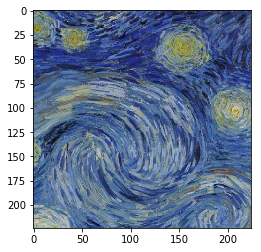

/home/cookiefactory/styletransfer/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 1s
start style gram
style gram done
start style cdf
layer0 done
layer1 done
style cdf done


In [15]:
#create style data from style image
with tf.device(device):
    sess = tf.Session()
    
    #load style image
    input_img = get_image("./test_data/starrynight_small.jpg")  

    #input vgg
    input_image = tf.constant(input_img, tf.float32)
    
    #create style vgg()
    vgg = vgg19.Vgg19()    
    with tf.name_scope("style"):
        vgg.build(input_image)
    
    # define layers
    style_gram_layers = [vgg.conv1_1, vgg.pool1_avg, vgg.pool2_avg, vgg.pool3_avg, vgg.pool4_avg]
    style_hist_layers = [vgg.conv1_1, vgg.conv4_1]
    
    # loop through the layer to obtain the gram matrices per layer
    print('start style gram')
    style_gram_matrices = sess.run(get_gram_matrices(style_gram_layers))
    style_layer_grams = []
    
    for style_gram_matrix in style_gram_matrices:
        style_layer_grams.append(tf.constant(style_gram_matrix))
    print('style gram done')
        
        
    # loop through the layers to obtain the histograms and cdfs per feature
    style_layer_cdfs = []
    
    print('start style cdf')
    for l, style_hist_layer, grouping in zip(range(2), style_hist_layers, hist_grouping):
        print('layer', end = '')
        print(l, end = '')
        
        # get dimensions
        dimensions = style_hist_layer.get_shape().as_list()        
        
        layer_cdfs = []
        
        for featureIdx in range(int(dimensions[3]/grouping)):
            feature = tf.squeeze(tf.slice(style_hist_layer,[0,0,0,featureIdx*grouping],[1,dimensions[1],dimensions[2],grouping]))
            
            # get histogram
            feature_histogram, _ = histogram_fixed_width(feature, hist_range, hist_bins)
            # get cdf
            feature_cdf = cumulative_sum(feature_histogram)
            # append cdf
            layer_cdfs.append(tf.constant(sess.run(feature_cdf)))
        
        style_layer_cdfs.append(layer_cdfs)
        
        print(' done')
        
    print('style cdf done')


get noise image


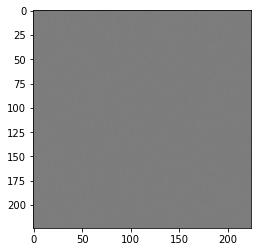

/home/cookiefactory/styletransfer/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 1s
get layers


In [16]:
    #create target image
    print('get noise image')
    source = tf.Variable((create_noise_image(224, 224, noise_min, noise_max)), tf.float32)
                 
    #create vgg  
    vgg = vgg19.Vgg19() 
    with tf.name_scope("source"):
        vgg.build(source)                 
    
    #target vgg layers
    print('get layers')
    source_gram_layers = [vgg.conv1_1, vgg.pool1_avg, vgg.pool2_avg, vgg.pool3_avg, vgg.pool4_avg]
    source_hist_layers = [vgg.conv1_1, vgg.conv4_1]
    source_tv_layers = [source, vgg.conv1_1]


In [17]:
    #get source gram matrices per layer
    print('start gram loss')
    source_layer_gram = get_gram_matrices(source_gram_layers)
    gram_loss = gram_weight * get_gram_loss(source_layer_gram, style_layer_grams, gram_layer_weight)
    print('gram loss done')
    
    #get source histogram
    print('start histogram loss')
    hist_loss = hist_weight * get_histogram_loss(source_hist_layers, style_layer_cdfs, hist_layer_weight, hist_grouping, hist_range, hist_bins)
    print('hist loss done')
    
    #get total variation loss
    print('start total variation loss')
    tv_loss = tv_weight * get_tv_loss(source_tv_layers, tv_layer_weight)
    print('total variation loss done')
    
    #get all losses
    loss = [gram_loss, hist_loss, tv_loss]

start gram loss
gram loss done
start histogram loss
hist loss done
start total variation loss
total variation loss done


In [18]:
    i=0
    def callback(loss,source):
        global i
        source = tf.minimum(tf.maximum(source,0.0),1)

        if (optimizer_plot == True):
            wall_time = time.time() - start_time


        print(i, end = '')
        print(' ', end = '')

        if((i+1) % i_print == 0):

            #print loss
            print('')
            # loss_compute = sess.run(loss)
            print('Loss evaluation #', i, ', loss:', loss)

            if (optimizer_plot == True):
                loss_graph.append((wall_time, loss))

            #show image
            if(show == True):
                plt.imshow(sess.run(tf.reshape(source,(224,224,3))))
                plt.show()

        i += 1

minimizing
0 1 2 3 4 5 6 7 8 9 
Loss evaluation # 9 , loss: 1.5375e+10


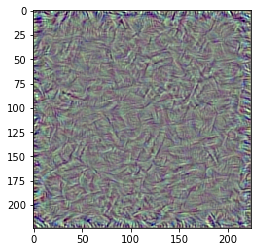

10 11 12 13 14 15 minimized
Task took 89.52 seconds, 0.09 seconds/iteration


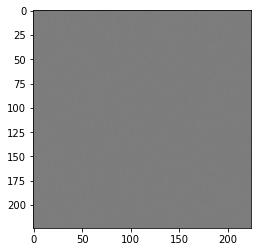

In [20]:
    #L-BFGS-B Optimizer not honoring maximum iterations given
    # see https://github.com/scipy/scipy/issues/3334
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss,method='L-BFGS-B',options={'maxfun': i_max})
       
    sess.run(tf.global_variables_initializer())
    print("minimizing")
           
    if (optimizer_plot == True):
        start_time = time.time()
    
    try:
        optimizer.minimize(sess,fetches =[tf.reduce_sum(loss), source], loss_callback=callback)
    
    # Just proceed happily if user interrupts program
    except KeyboardInterrupt:
        pass
    
    if (optimizer_plot == True):
        wall_time = time.time() - start_time
    print("minimized")
    print ('Task took {:.2f} seconds, {:.2f} seconds/iteration'.format(wall_time, wall_time/i_max))  
   
    # print(sess.run(loss, feed_dict = feed))
    # print(sess.run(get_loss(target_layers, style_layers), feed_dict = feed))
   
    #show image
    if(show == True):
        plt.imshow(sess.run(tf.reshape(source,(224,224,3))))
        plt.show()


In [ ]:
# Plot the loss over time
# loss_graph = np.asarray(loss_graph)
fig = plt.figure()
plot = plt.plot(loss_graph[:, 0], loss_graph[:, 1])
plt.xlabel('Wall time (seconds)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim([90, 250])
# fig.savefig('{}-{}.pdf'.format() #TODO: save image